In [1]:
pip install statsmodels

     ---------------------------------------- 9.1/9.1 MB 24.3 MB/s eta 0:00:00
  Using cached patsy-0.5.2-py2.py3-none-any.whl (233 kB)
Note: you may need to restart the kernel to use updated packages.


COVID-19 cases prediction using ARIMA

In [1]:
import warnings                                  
warnings.filterwarnings('ignore')
import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                          
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook

In [10]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [4]:
#importing dataset
df = pd.read_csv('/data/BHI_G5/daily_agg_county/county_daily_aggregated_timeseries.csv')
df['date'] = pd.DatetimeIndex(df['date'])
df = df.set_index('date')

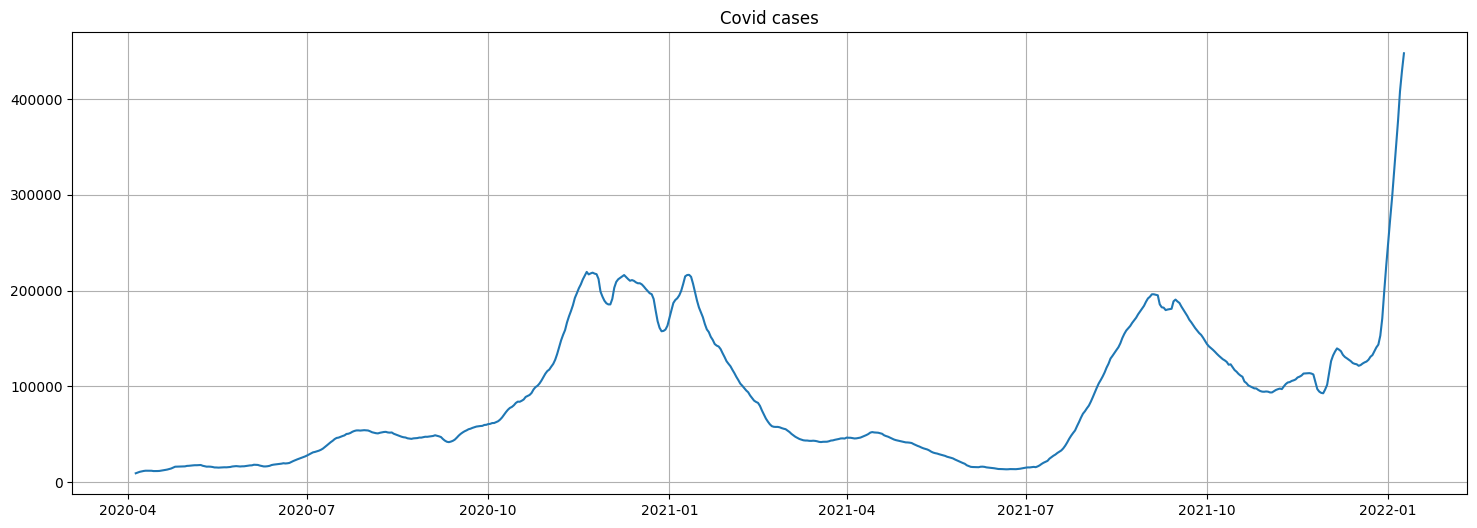

In [5]:
plt.figure(figsize=(18, 6))
plt.plot(df['metrics.caseDensity'])
plt.title('Covid cases')
plt.grid(True)
plt.show()

In [11]:
plot(df['metrics.caseDensity'], lags=60)

In [7]:
# The seasonal difference
cases_diff = df['metrics.caseDensity'] - df['metrics.caseDensity'].shift(7)
plot(cases_diff[7:], lags=60)

In [12]:
cases_first_diff = cases_diff - cases_diff.shift(1)
plot(cases_first_diff[7+1:], lags=60)

In [13]:
#setting initial values for p,d,q by defining lower and upper limits
p = range(2, 7)
d=1 
q = range(2, 7)
P = range(0, 2)
D=1 
Q = range(0, 2)
s = 7

#creating a list with all the possible combinations of the above parameters
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

100

In [14]:
def optimizeSARIMA(y, parameters_list, d, D, s):

    output = []
    best_aic = float("inf")
    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        output.append([param, model.aic])
    parameter_result_table = pd.DataFrame(output)
    parameter_result_table.columns = ['parameters', 'aic']
    parameter_result_table = parameter_result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return parameter_result_table

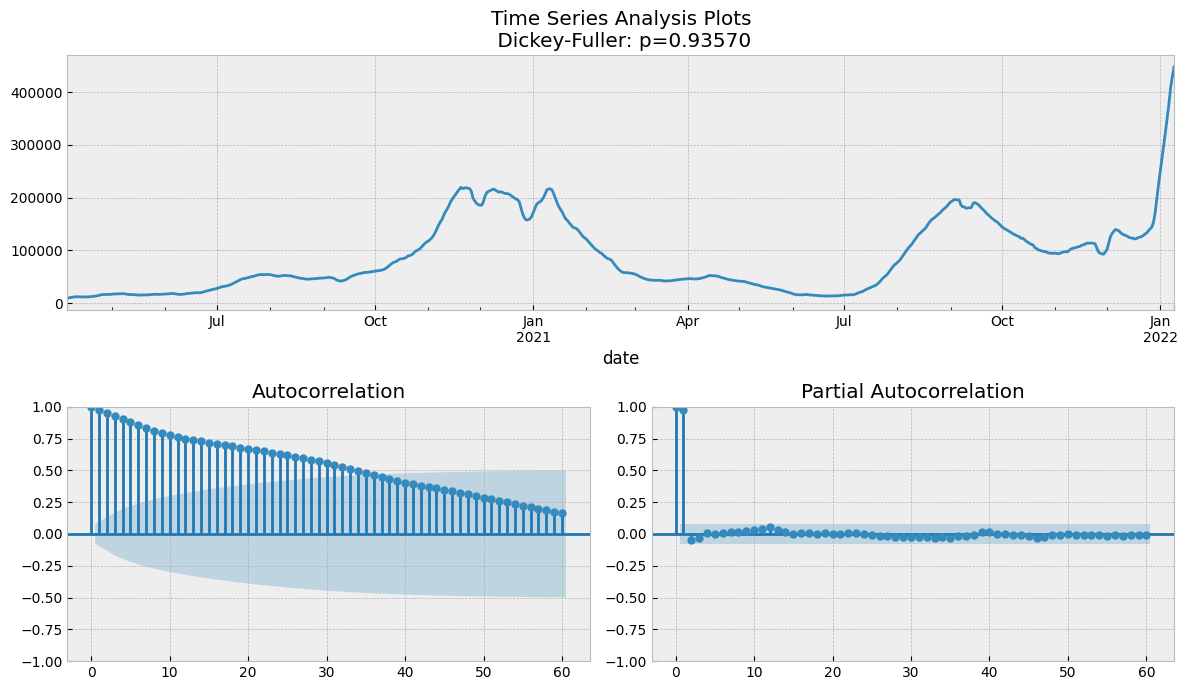

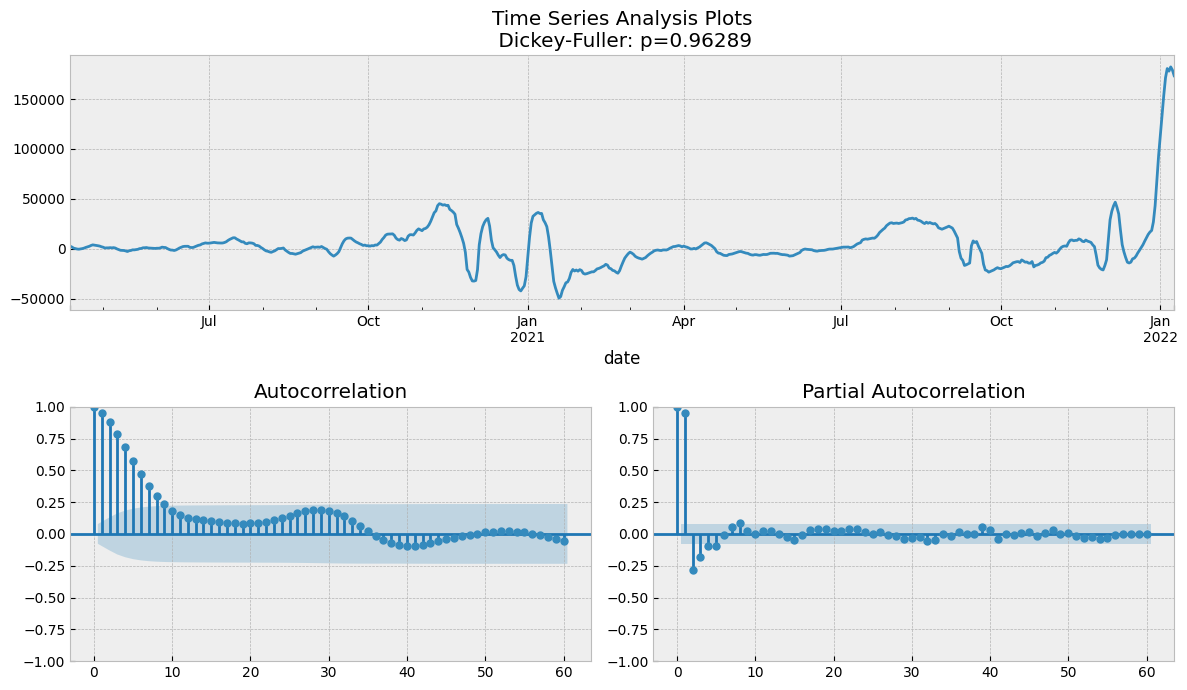

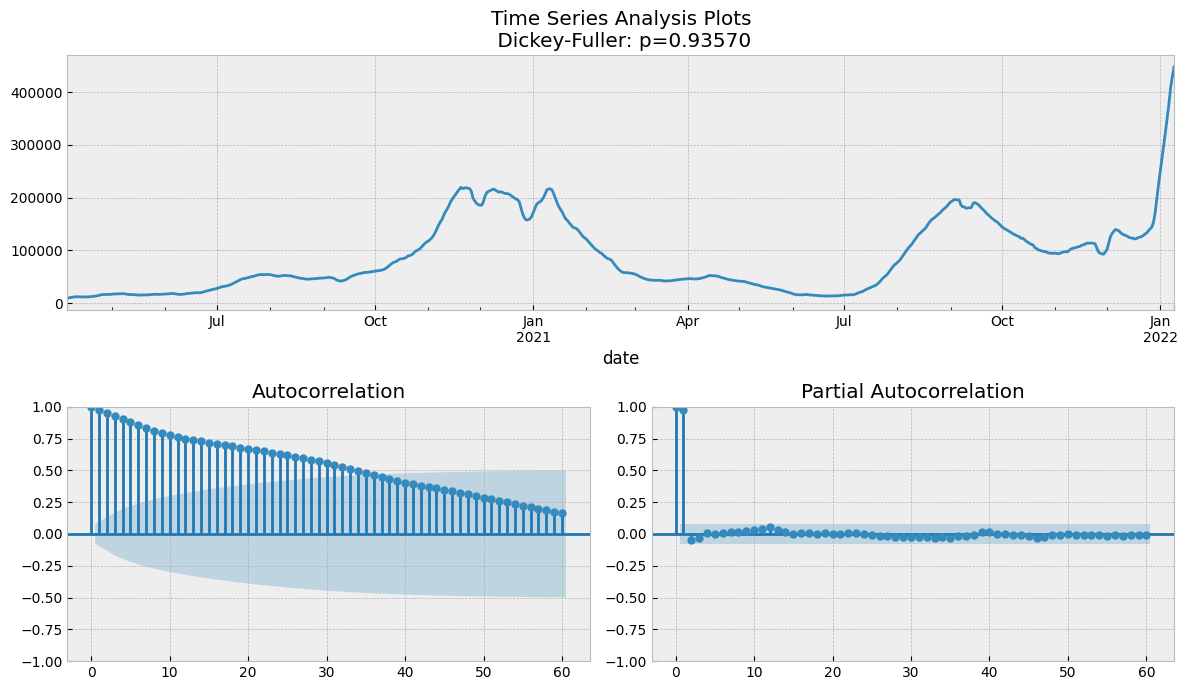

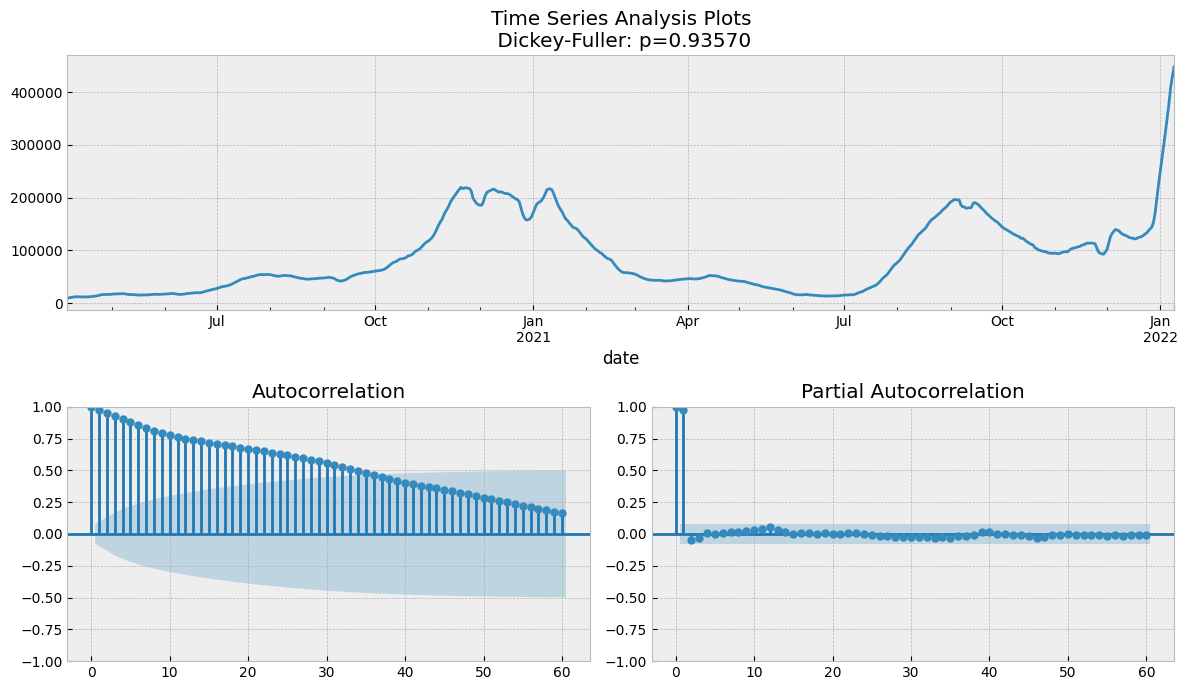

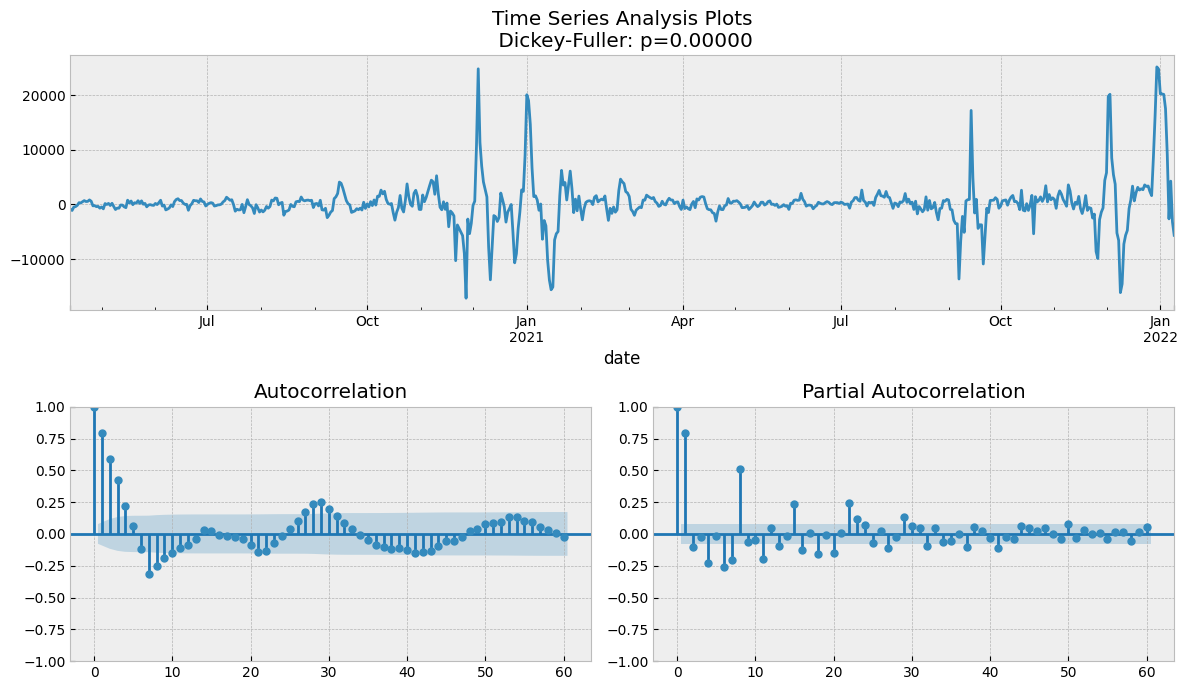

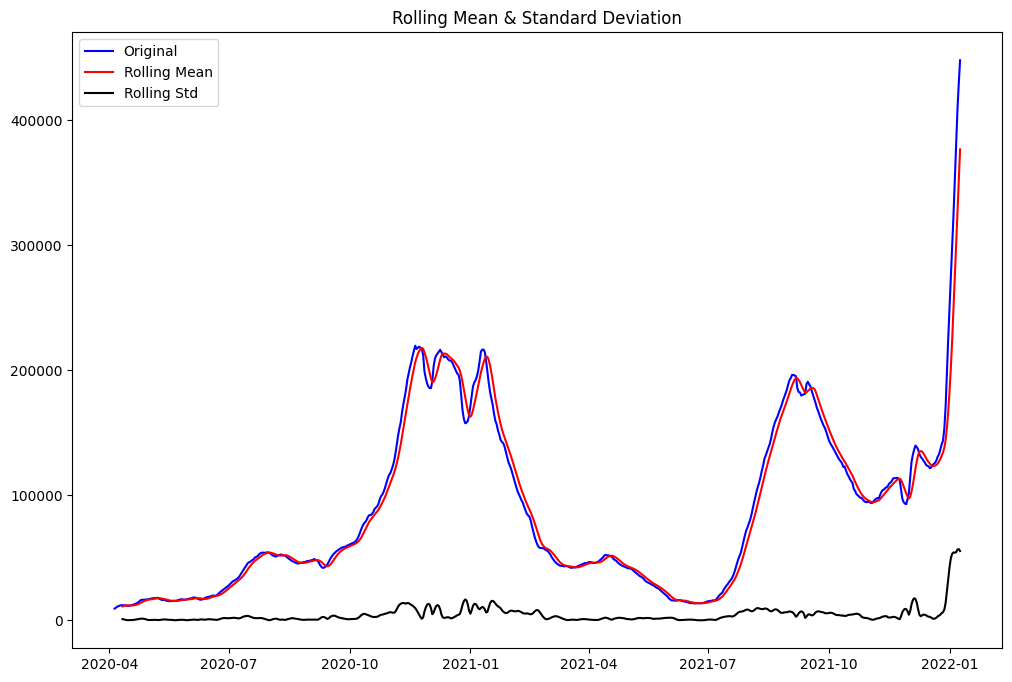

In [15]:
#Determining rolling statistics
rolmean = df['metrics.caseDensity'].rolling(7).mean()
rolstd = df['metrics.caseDensity'].rolling(7).std()

#Plotting rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(df['metrics.caseDensity'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import math

#Prediction for 14days Dec 28th to Jan 9th mean
train = df['metrics.caseDensity'].iloc[:631].rolling(7).mean()
test = df['metrics.caseDensity'].iloc[631:].rolling(7).mean()
warnings.filterwarnings("ignore") 
parameter_result_table = optimizeSARIMA(train, parameters_list, d, D, s)

#Saving the parameters to a csv file
parameter_result_table
parameter_result_table.to_csv("result_table_cases_14daypredictionmean.csv")

#setting the parameters that give the lowest AIC
p, q, P, Q = parameter_result_table.parameters[0]
best_model=sm.tsa.statespace.SARIMAX(train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())
plot(best_model.resid[7+1:], lags=2)

def plotSARIMA(series, model, n_steps):
    
    #assigning model values
    data = series.copy()
    data['actual'] = df['metrics.caseDensity']
    test = df['metrics.caseDensity'].iloc[631:].rolling(7).mean()
    data['sarima_model'] = test
    test = model.fittedvalues
    test[:s+d] = np.NaN
    
    #forecasting 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], test[s+d:])
    
    #Calculating the performance metrics
    print("MAPE: ", error)
    MSE = np.square(np.subtract(abs(data['actual'][s+d:]), abs(test[s+d:]))).mean()
    print("MSE:", MSE)
    RMSE = math.sqrt(MSE)
    print("Root Mean Square Error:\n")
    print(RMSE)
    plt.figure(figsize=(15, 7))
    plt.title("Actual v/s Predicted Covid Cases")
    plt.plot(forecast, color='r', label="predicted")
    plt.ylim(0, 600000)
    plt.axvspan(data.index[0], forecast.index[0], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.ylabel("Covid cases")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.savefig('/data/BHI_G5/plots/ARIMA/metrics.caseDensity14daypredictionmean.png')
    plt.savefig('/data/BHI_G5/plots/ARIMA/metrics.caseDensity14daypredictionmean.png', format="pdf")

plotSARIMA(df['metrics.caseDensity'], best_model, 1)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import math

#Prediction for delta and omicron wave mean
train = df['metrics.caseDensity'].iloc[:483].rolling(7).mean()
test = df['metrics.caseDensity'].iloc[483:].rolling(7).mean()
warnings.filterwarnings("ignore") 
parameter_result_table = optimizeSARIMA(train, parameters_list, d, D, s)

#Saving the parameters to a csv file
parameter_result_table
parameter_result_table.to_csv("result_table_cases_deltaomicronmean.csv")

#setting the parameters that give the lowest AIC
p, q, P, Q = parameter_result_table.parameters[0]
best_model=sm.tsa.statespace.SARIMAX(train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())
plot(best_model.resid[7+1:], lags=2)

def plotSARIMA(series, model, n_steps):
    
    #assigning model values
    data = series.copy()
    data['actual'] = df['metrics.caseDensity']
    test = df['metrics.caseDensity'].iloc[483:].rolling(7).mean()
    data['sarima_model'] = test
    test = model.fittedvalues
    test[:s+d] = np.NaN
    
    #forecasting 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], test[s+d:])
    
    #Calculating the performance metrics
    print("MAPE: ", error)
    MSE = np.square(np.subtract(abs(data['actual'][s+d:]), abs(test[s+d:]))).mean()
    print("MSE:", MSE)
    RMSE = math.sqrt(MSE)
    print("Root Mean Square Error:\n")
    print(RMSE)
    plt.figure(figsize=(15, 7))
    plt.title("Actual v/s Predicted Covid Cases")
    plt.plot(forecast, color='r', label="predicted")
    plt.ylim(0, 600000)
    plt.axvspan(data.index[0], forecast.index[0], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.ylabel("Covid cases")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.savefig('/data/BHI_G5/plots/ARIMA/metrics.caseDensitydeltaomicronpredictionmean.png')
    plt.savefig('/data/BHI_G5/plots/ARIMA/metrics.caseDensitydeltaomicronpredictionmean.png', format="pdf")

plotSARIMA(df['metrics.caseDensity'], best_model, 1)

COVID-19 deaths prediction using ARIMA

In [17]:
import warnings                                  
warnings.filterwarnings('ignore')
import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                          
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook

In [18]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [19]:
#importing dataset
df = pd.read_csv('/data/BHI_G5/daily_agg_county/county_daily_aggregated_timeseries.csv')
df['date'] = pd.DatetimeIndex(df['date'])
df = df.set_index('date')

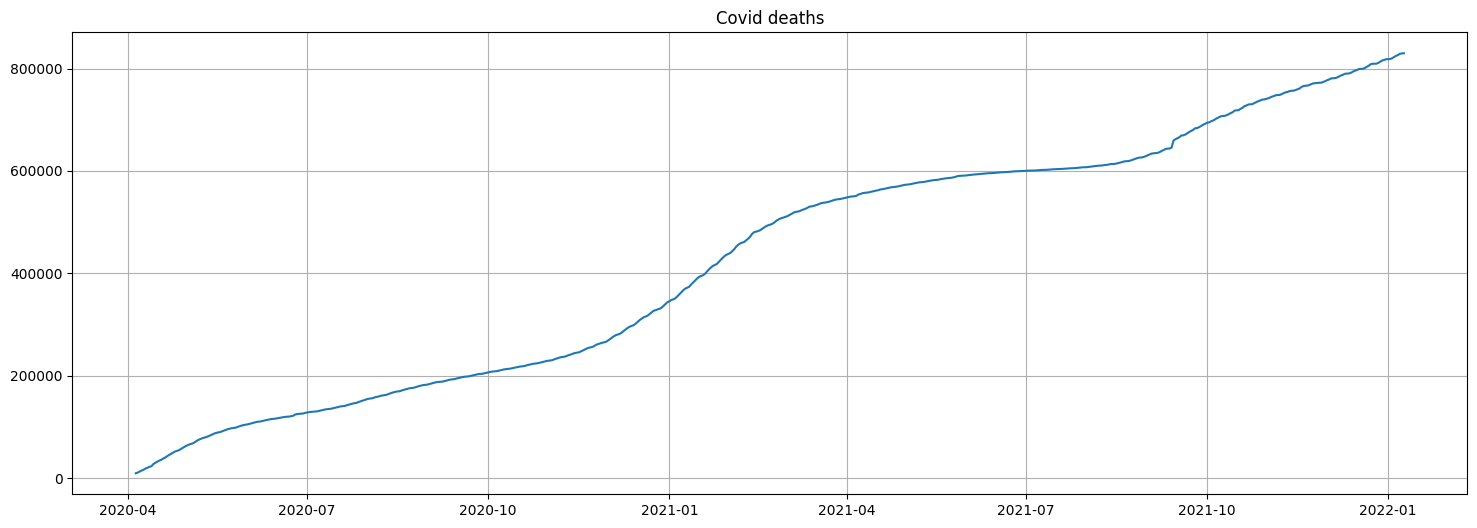

In [20]:
plt.figure(figsize=(18, 6))
plt.plot(df['actuals.deaths'])
plt.title('Covid deaths')
plt.grid(True)
plt.show()

In [21]:
plot(df['actuals.deaths'], lags=60)

In [22]:
# The seasonal difference
deaths_diff = df['actuals.deaths'] - df['actuals.deaths'].shift(7)
plot(deaths_diff[7:], lags=60)

In [23]:
deaths_first_diff = deaths_diff - deaths_diff.shift(1)
plot(deaths_first_diff[7+1:], lags=60)

In [16]:
#setting initial values for p,d,q by defining lower and upper limits
p = range(2, 7)
d=1 
q = range(2, 7)
P = range(0, 2)
D=1 
Q = range(0, 2)
s = 7

#creating a list with all the possible combinations of the above parameters
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

100

In [24]:
def optimizeSARIMA(y, parameters_list, d, D, s):

    output = []
    best_aic = float("inf")
    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        output.append([param, model.aic])
    parameter_result_table = pd.DataFrame(output)
    parameter_result_table.columns = ['parameters', 'aic']
    parameter_result_table = parameter_result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return parameter_result_table

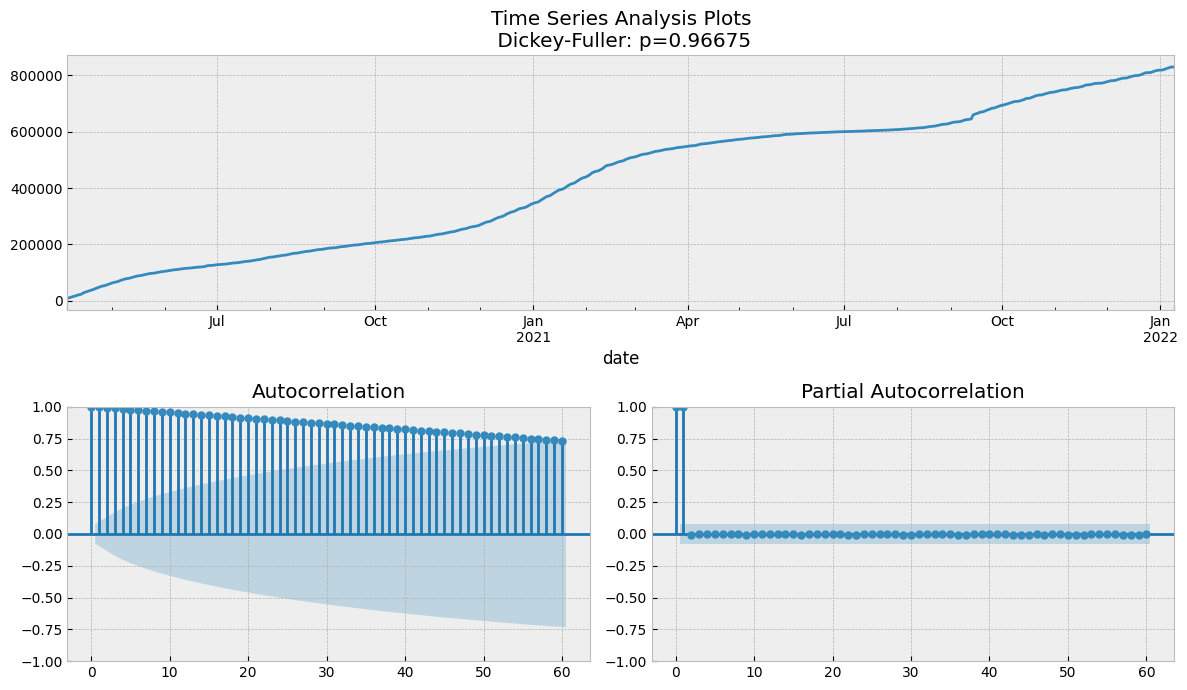

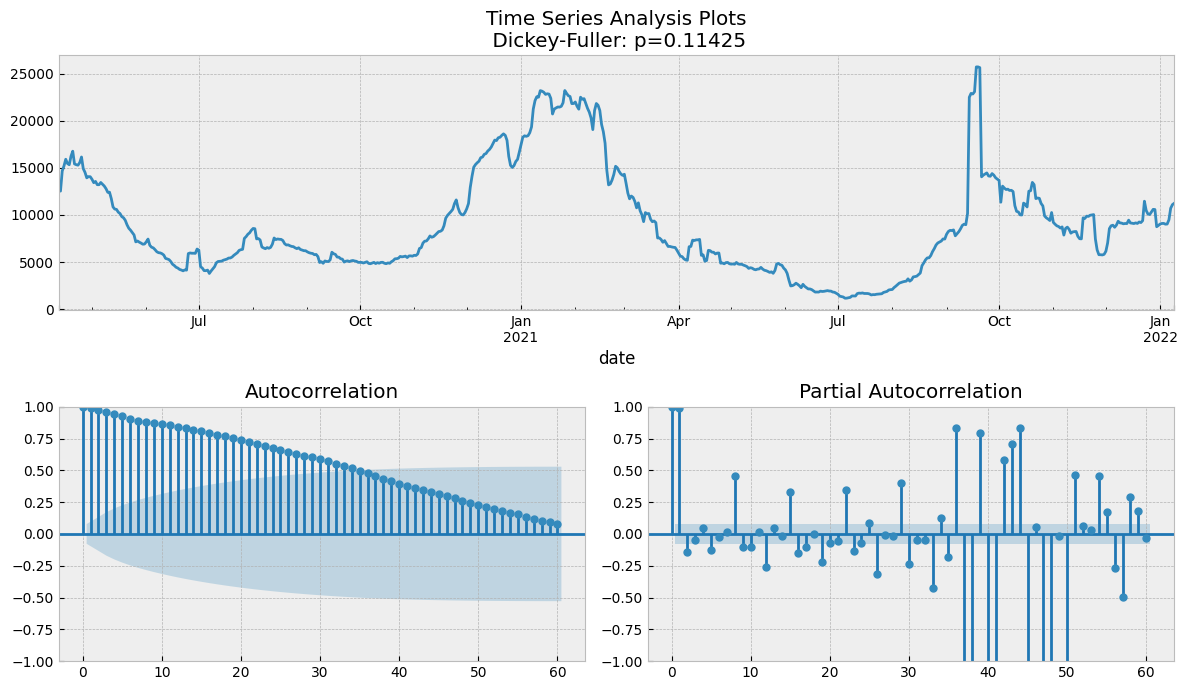

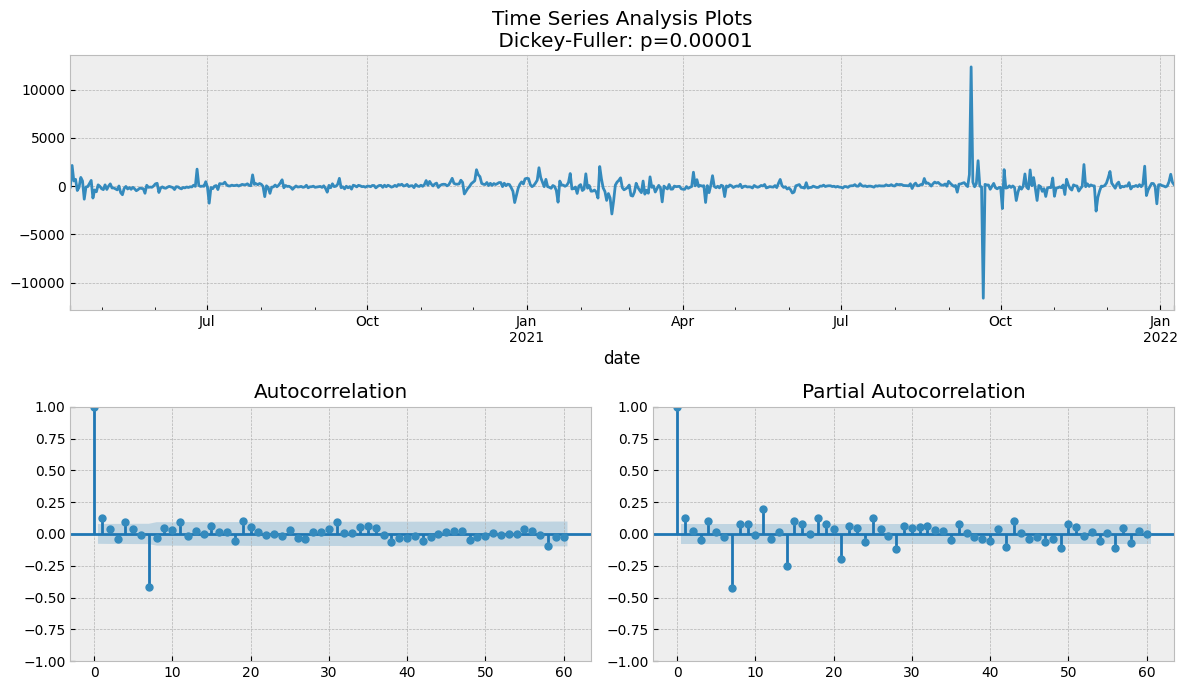

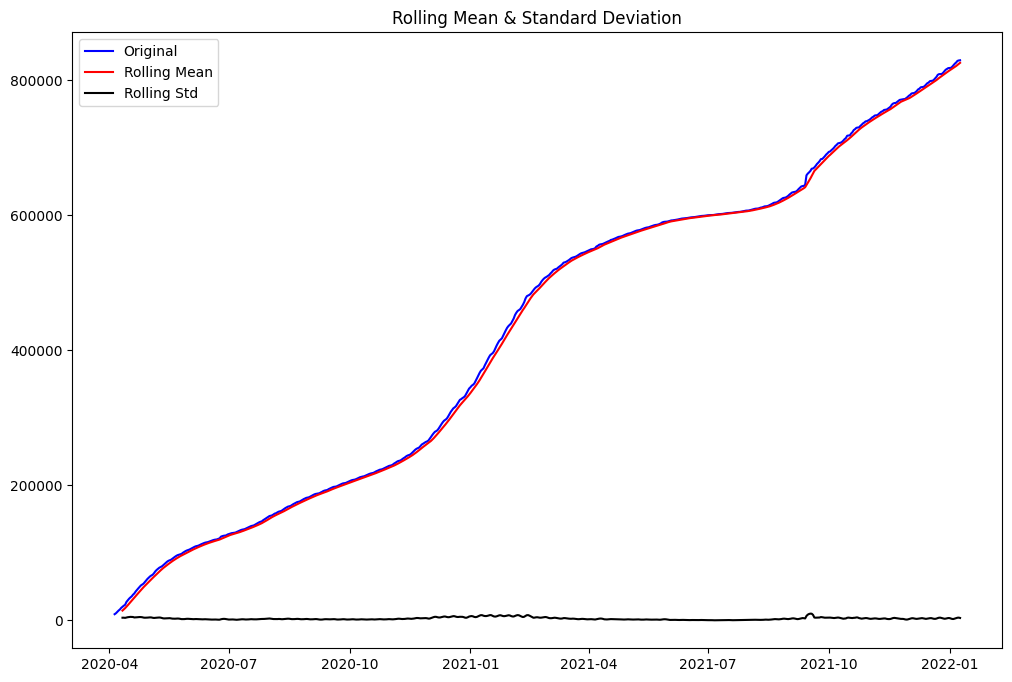

In [25]:
#Determining rolling statistics
rolmean = df['actuals.deaths'].rolling(7).mean()
rolstd = df['actuals.deaths'].rolling(7).std()

#Plotting rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(df['actuals.deaths'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import math

#Prediction for 14days Dec 28th to Jan 9th mean
train = df['actuals.deaths'].iloc[:631].rolling(7).mean()
test = df['actuals.deaths'].iloc[631:].rolling(7).mean()
warnings.filterwarnings("ignore") 
parameter_result_table = optimizeSARIMA(train, parameters_list, d, D, s)

#Saving the parameters to a csv file
parameter_result_table
parameter_result_table.to_csv("result_table_deaths_14daypredictionmean.csv")

#setting the parameters that give the lowest AIC
p, q, P, Q = parameter_result_table.parameters[0]
best_model=sm.tsa.statespace.SARIMAX(train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())
plot(best_model.resid[7+1:], lags=2)

def plotSARIMA(series, model, n_steps):
    
    #assigning model values
    data = series.copy()
    data['actual'] = df['actuals.deaths']
    test = df['actuals.deaths'].iloc[631:].rolling(7).mean()
    data['sarima_model'] = test
    test = model.fittedvalues
    test[:s+d] = np.NaN
    
    #forecasting
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], test[s+d:])
    
    #Calculating the performance metrics
    print("MAPE: ", error)
    MSE = np.abs(np.square(np.subtract(data['actual'][s+d:], test[s+d:])).mean())
    print("MSE:", MSE)
    RMSE = math.sqrt(MSE)
    print("Root Mean Square Error:\n")
    print(RMSE)
    plt.figure(figsize=(15, 7))
    plt.title("Actual v/s Predicted Covid Deaths")
    plt.plot(forecast, color='r', label="predicted")
    plt.ylim(0, 900000)
    plt.axvspan(data.index[0], forecast.index[0], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.ylabel("Covid deaths")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.savefig('/data/BHI_G5/plots/ARIMA/metrics.actuals.deaths14daypredictionmean.png')
    plt.savefig('/data/BHI_G5/plots/ARIMA/metrics.actuals.deaths14daypredictionmean.png', format="pdf")
    
plotSARIMA(df['actuals.deaths'], best_model, 2)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import math

#Prediction for delta and omicron wave mean
train = df['actuals.deaths'].iloc[:483].rolling(7).mean()
test = df['actuals.deaths'].iloc[483:].rolling(7).mean()
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(train, parameters_list, d, D, s)

#Saving the parameters to a csv file
result_table
result_table.to_csv("result_table_deaths_deltaomicronmean.csv")

#setting the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]
best_model=sm.tsa.statespace.SARIMAX(train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())
plot(best_model.resid[7+1:], lags=2)

def plotSARIMA(series, model, n_steps):
    
    #assigning model values
    data = series.copy()
    data['actual'] = df['actuals.deaths']
    test = df['actuals.deaths'].iloc[483:].rolling(7).mean()
    data['sarima_model'] = test
    test = model.fittedvalues
    test[:s+d] = np.NaN
    
    #forecasting
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], test[s+d:])
    
    #Calculating the performance metrics
    print("MAPE: ", error)
    MSE = np.abs(np.square(np.subtract(data['actual'][s+d:], test[s+d:])).mean())
    print("MSE:", MSE)
    RMSE = math.sqrt(MSE)
    print("Root Mean Square Error:\n")
    print(RMSE)
    plt.figure(figsize=(15, 7))
    plt.title("Actual v/s Predicted Covid Deaths")
    plt.plot(forecast, color='r', label="predicted")
    plt.ylim(0, 900000)
    plt.axvspan(data.index[0], forecast.index[0], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.ylabel("Covid deaths")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.savefig('/data/BHI_G5/plots/ARIMA/metrics.actuals.deathsdeltaomicronpredictionmean.png')
    plt.savefig('/data/BHI_G5/plots/ARIMA/metrics.actuals.deathsdeltaomicronpredictionmean.png', format="pdf")
    
plotSARIMA(df['actuals.deaths'], best_model, 1)